In [109]:
import numpy as np
import os 
import geopandas as gp
import geopandas.tools
import matplotlib.pyplot as plt
import pandas as pd 
import requests
import json
import io
from shapely.geometry import Point

import pylab as pl
%pylab inline
import statsmodels.api as sm
import statsmodels.formula.api as smf


from fiona.crs import from_epsg

#====

#import scipy.stats
#from geopy.geocoders import Nominatim


#import statsmodels.api as sm
#import statsmodels.formula.api as smf



Populating the interactive namespace from numpy and matplotlib


/Users/seastar/anaconda2/envs/py35/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


ImportError: No module named 'statsmodels'

In [8]:
!ls -l

total 3640
-rw-r--r--  1 seastar  staff   195287 Nov 30 19:05 HW9_as9788_assignment2-Copy1.ipynb
-rw-r--r--  1 seastar  staff   195287 Nov 30 18:56 HW9_as9788_assignment2.ipynb
-rw-r--r--  1 seastar  staff    15978 Nov 28 18:54 Untitled5.ipynb
-rwxr-xr-x@ 1 seastar  staff    17784 Nov 28 18:42 geo_export_893b1e61-1d08-411f-9ce4-db20c76bb4f2.dbf
-rwxr-xr-x@ 1 seastar  staff      212 Nov 28 18:42 geo_export_893b1e61-1d08-411f-9ce4-db20c76bb4f2.prj
-rwxr-xr-x@ 1 seastar  staff  1425020 Nov 28 18:42 geo_export_893b1e61-1d08-411f-9ce4-db20c76bb4f2.shp
-rwxr-xr-x@ 1 seastar  staff      540 Nov 28 18:42 geo_export_893b1e61-1d08-411f-9ce4-db20c76bb4f2.shx


In [2]:
 pumashp = geopandas.GeoDataFrame.from_file('geo_export_893b1e61-1d08-411f-9ce4-db20c76bb4f2.shp')

In [3]:
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [4]:
pumashp.crs

{'init': 'epsg:4326'}

In [5]:
# using the built in plot function as pumashp.plot(pumashp....)
# using a choroplethNYC function that FBB wrote
import choroplethNYC as cp
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2);

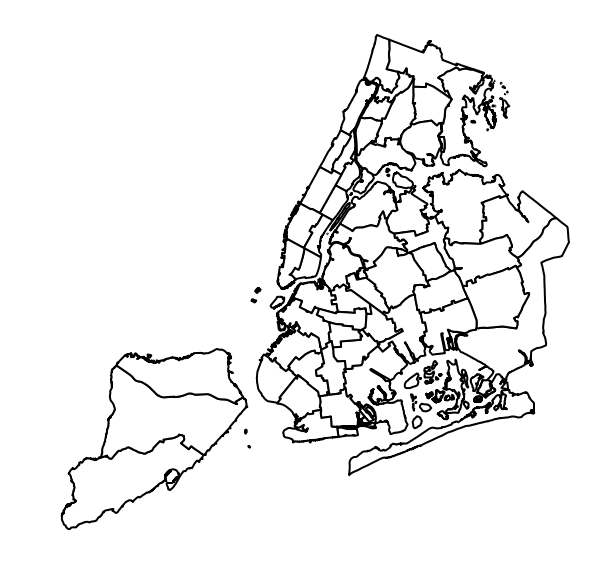

In [6]:
#pumashp.plot()
plt.show()
#plt.text ('this is a plot of NYC shapefile')

#fig.text(.5, .05, txt, ha='center')

In [7]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [8]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))
#Python2
#affkeys = np.array(aff1y['variables'].keys())

In [9]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_004MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_008M',
  'Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_008EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 (

In [10]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [11]:
#('B28002_004E',
 # 'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),

#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [12]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" 
#",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [13]:
pumaBB.iloc[0]

B28002_004E                                               32607
NAME                         St. Lawrence County PUMA, New York
state                                                        36
public use microdata area                                   100
Unnamed: 4                                                  NaN
Name: 0, dtype: object

In [21]:
#keyword for the number of households
#keyNhouseholds = 'B28002_001E'
#aff1y['variables'][keyNhouseholds]

# getting the broadband access number of households
#url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
#",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" 
#",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
#resp = requests.request('GET', url).content
#pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

#pumaBB.head()

In [14]:
#getting the first row of the table: the total number of households
url =   "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key="
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [15]:
pumaPP_d = pumaPP.drop('Unnamed: 4', axis=1)


In [16]:
pumaBB_d = pumaBB.drop('Unnamed: 4', axis=1)

In [17]:
pumaBB_d.head()

,B28002_004E,NAME,state,public use microdata area
0,32607,"St. Lawrence County PUMA, New York",36,100
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200
2,41210,"Warren & Washington Counties PUMA, New York",36,300
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402


In [18]:
#2.2 generate a feature for the percentage of households with broadband access

#pd.concat([pumaBB, pumaPP], axis=1)

puma_m = pd.merge(pumaBB_d, pumaPP_d, on=['public use microdata area','NAME','state'],how='inner')

In [19]:
puma_m.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E
0,32607,"St. Lawrence County PUMA, New York",36,100,40479
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146


In [37]:
# colummn B28002_004E divided by B28002_004E
#df['C'] = df['A'] + df['B']
#puma_m['pcBB'] = puma_m['B28002_004E'].astype(float)  /  puma_m['B28002_001E'].astype(float)
puma_m['pcBB'] = (puma_m['B28002_004E']  /  puma_m['B28002_001E'])*100
#float(df['A'])

In [38]:
puma_m.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


In [30]:
#ACS_16_1YR_GCT2801.ST50_with_ann.csv
#!ls -l $PUIDATA/ACS_16_1YR_GCT2801.ST50_with_ann.csv

In [39]:
acs_file = !echo $PUIDATA/ACS_16_1YR_GCT2801.ST50_with_ann.csv
#print(acs_file)


In [32]:
#acs_data = pd.read_csv(acs_file, encoding = "ISO-8859-1")
#acs_data = pd.read_csv('filename, encoding = "ISO-8859-1")
#ead_csv('file', encoding = "ISO-8859-1"), or alternatively encoding = utf8 for reading, and generally utf-8 for to_csv.

#You can also use the alias 'latin1' instead of 'ISO-8859-1'.



In [33]:
#acs_data.head()

In [40]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
                   usecols=["Target Geo Id2","Percent", "Margin of Error"], header=1)
            #usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])
            
bbpc.head()

,Target Geo Id2,Percent,Margin of Error
0,1,74.7,0.5
1,100100,70.9,2.5
2,100200,80.5,2.7
3,100301,87.0,2.8
4,100302,81.9,2.9


In [41]:
#make the rows the titles 
bbpc["gid"] = bbpc["Target Geo Id2" ]- 3600000 
# make new geo id 
bbpc.head()

,Target Geo Id2,Percent,Margin of Error,gid
0,1,74.7,0.5,-3599999
1,100100,70.9,2.5,-3499900
2,100200,80.5,2.7,-3499800
3,100301,87.0,2.8,-3499699
4,100302,81.9,2.9,-3499698


In [42]:
diff_ = puma_m.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "Percent"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["Percent"].astype(float))

diff_.describe()

,pcBB,Percent,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


In [37]:
#choropleth of the percentage of internet axcess



#puma_m = pd.merge(pumaBB_d, pumaPP_d, on=['public use microdata area','NAME','state'],how='inner')


#pumashp_b = pumashp.merge(puma_m, pumashp, on=['public use microdata area'], how = 'inner')

#cp.choroplethNYC(...);

In [38]:
#3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

#pd.merge(df_new, df_n, left_on='subject_id', right_on='subject_id')


In [43]:
puma_m.head()
#d1_puma = puma_m.var(columns=[ 'public use microdata area' ], dtype=float)


,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


In [44]:
puma_m[['public use microdata area']] = puma_m[['public use microdata area']].astype('int')

In [45]:
puma_m.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


In [46]:
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [47]:
pumashp[['puma']] = pumashp[['puma']].astype('int')

In [106]:
#pumashp_b.head()

In [48]:
pumashp['puma'].dtype

dtype('int64')

In [49]:
puma_m['public use microdata area'].dtype

dtype('int64')

In [50]:

pumashp_b = pumashp.merge(puma_m, right_on='public use microdata area', left_on= 'puma') 

In [51]:
pumashp_b.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,58706,69.425612


In [101]:
#cp.choroplethNYC(...);
#cp.choroplethNYC(pumashp_b,   edgecolor="black", lw=2); #color="white", column='pcBB',
#cp.choroplethNYC(pumashp_b)
#f, ax, cb = cp.choroplethNYC(pumashp_b, "pcBB", kind='continuous', cmap="viridis")
#plt.show()

#f, ax = plt.subplots(figsize=(10,10))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
#pumashp_b.plot(column='pcBB',alpha=1,linewidth=0.5,ax=ax, cmap='viridis')
#plt.title("pcBB map colored by boroughs")
#import matplotlib
#matplotlib.style.use('ggplot')
#cp.choroplethNYC(pumashp_b, column='pcBB')
#cp.choroplethNYC(pumashp_b, edgecolor="black", lw=2)

In [52]:
#help(pumashp_b)

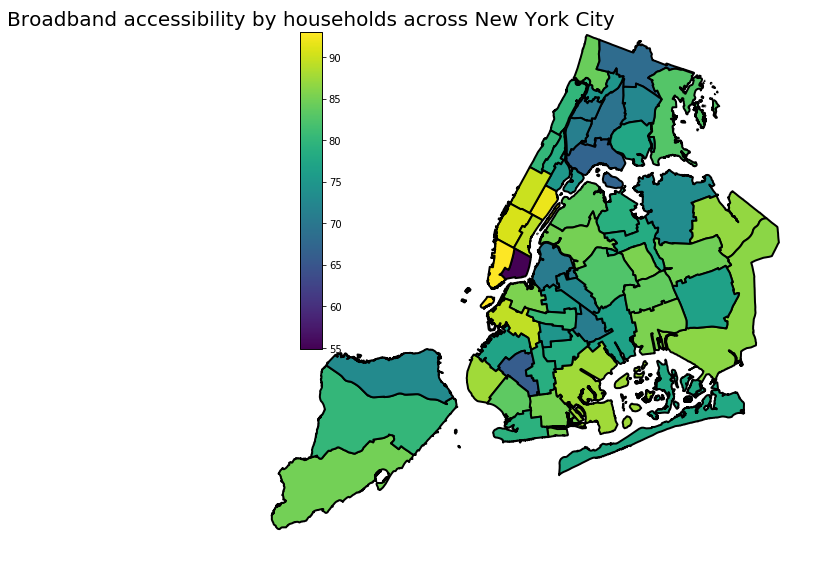

In [57]:
cp.choroplethNYC(pumashp_b, column='pcBB', edgecolor="black", lw=2) 
pl.title("Broadband accessibility by households across New York City", fontsize = 20)
plt.show()





In [58]:
#4.LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

#https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv
linkNYC = pd.read_csv('https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv')

linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [59]:
linkNYC.shape
#newcol = (linkNYC['latitude'], linkNYC['longitude'])

#print (newcol)
#linkNYC.assign(lonlat = newcol)
#newcol = np.log(df['A'])
#df.assign(ln_A=newcol)

(1414, 5)

In [60]:
#df['period'] = df['Year'].astype(str) + df['quarter']
linkNYC['lonlat']= ('('+linkNYC['latitude'].astype(str)+','+linkNYC['longitude'].astype(str)+')')
#df['combined']=df['bar'].astype(str)+'_'+df['foo']+'_'+df['new']
#linkNYC['lonlat']=(linkNYC.longitude,linkNYC.latitude)
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(40.70166753,-73.94248859)"
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(40.7015421938,-73.9421692831)"
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(40.7019303439,-73.9422392385)"
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(40.70506042,-73.94291758)"
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(40.728133,-73.953439)"


In [ ]:
#plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals
#I have also color coded the station by how long ago they have been installed, using the date datetime variable

In [61]:
#places = geopandas.GeoDataFrame(linkNYC, geometry="geometry")


#places = pandas.DataFrame(raw_data, columns=["name", "latitude", "longitude"])


# Create the geometry column from the coordinates
# Remember that longitude is east-west (i.e. X) and latitude is north-south (i.e. Y)
linkNYC["geometry"] = linkNYC.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
#del(places["latitude"], places["longitude"])

# Convert to a GeoDataFrame
linkNYC = geopandas.GeoDataFrame(linkNYC, geometry="geometry")
linkNYC.crs = {"init": "epsg:4326"}
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat,geometry
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(40.70166753,-73.94248859)",POINT (-73.94248859 40.70166753)
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(40.7015421938,-73.9421692831)",POINT (-73.9421692831 40.7015421938)
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(40.7019303439,-73.9422392385)",POINT (-73.94223923850001 40.7019303439)
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(40.70506042,-73.94291758)",POINT (-73.94291758 40.70506042)
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(40.728133,-73.953439)",POINT (-73.953439 40.728133)


In [62]:

# Perform the spatial join
result = geopandas.tools.sjoin(pumashp_b, linkNYC, how="right")

# Print the results...
result.head()

,index_left,puma,shape_leng,shape_area,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat,geometry
index_right,,,,,,,,,,,,,,,,,
1286,0,3701,53227.144376,9.792852e+07,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1286,bx-08-145850,-73.902101,2017-06-10,40.868698,"(40.86869849,-73.9021009)",POINT (-73.90210090000002 40.86869849)
927,4,3705,68593.066759,1.224946e+08,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,58706,69.425612,927,bx-06-118922,-73.898221,2017-10-20,40.846926,"(40.8469261747,-73.898220556)",POINT (-73.898220556 40.84692617469999)
917,5,3706,51799.404764,4.388687e+07,34391,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,46018,74.733800,917,bx-05-119659,-73.893343,2016-12-06,40.860027,"(40.860027,-73.893343)",POINT (-73.893343 40.860027)
25,5,3706,51799.404764,4.388687e+07,34391,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,46018,74.733800,25,bx-05-116218,-73.893059,2016-05-12,40.860215,"(40.86021467,-73.89305944)",POINT (-73.89305944 40.86021467)
1283,5,3706,51799.404764,4.388687e+07,34391,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,46018,74.733800,1283,bx-05-145959,-73.897400,2017-10-06,40.861150,"(40.86115,-73.8974)",POINT (-73.8974 40.86115)


In [154]:
#combine long lat into a column like you did in the lab to greate a "geometry" 
#column for the dataframe, then convert the dataframe into a GeoDataFrame linkNYC and set 
#native coordinates frame to lat/lon as you did in the lab


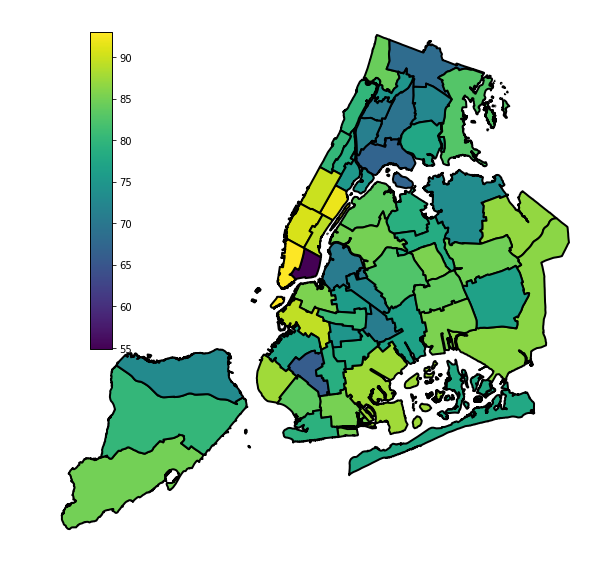

In [63]:
#linkNYC.crs = ...
#fig, ax, cb = choroplethNYC.choroplethNYC(precincts, "shape_area", cb=True)
#import choroplethNYC as cp
#cp.choroplethNYC(pumashp_b, column='pcBB', edgecolor="black", lw=2) 
#plt.show()

In [69]:
#import choroplethNYC as cp
#item, axes, fig = cp.choroplethNYC(result, column='pcBB', edgecolor="black", lw=2) 
#plt.show()



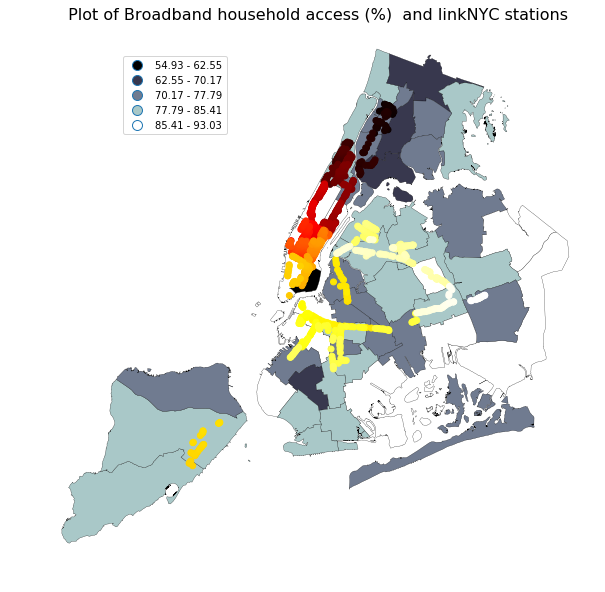

In [70]:
item, fig, axes = cp.choroplethNYC(pumashp_b, column = "pcBB", cmap='bone', edgecolor='black', lw=.25, 
                          scheme='equal_interval',k=5);
cp.choroplethNYC(result, ax=fig, cmap="hot");
pl.title(" Plot of Broadband household access (%)  and linkNYC stations across NYC", fontsize = 16);
plt.show()

In [ ]:

#Section 5:  Find the number of linkNYC locations per person by PUMA
#5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

In [ ]:
#Key for Population is: B00001_001E

In [71]:
keyPOP = 'B00001_001E'
aff1y['variables'][keyPOP]

{'attributes': 'B00001_001EA',
 'concept': 'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 'group': 'B00001',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [72]:
# getting population 
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPOP +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" 
#",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPOP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPOP.head()

#Column B000001_001E is population 

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [73]:
pumashp_b.columns

Index(['puma', 'shape_leng', 'shape_area', 'geometry', 'B28002_004E', 'NAME',
       'state', 'public use microdata area', 'B28002_001E', 'pcBB'],
      dtype='object')

In [ ]:
#5.2 find the number of station per 100 people per PUMA

In [97]:
pumashp_c['geometry'] = pumashp_b['geometry'].to_crs(epsg=2263)

In [98]:
#pumashp.merge()
pumashp_c = pumashp_b.merge(pumaPOP, right_on="public use microdata area", 
                     left_on="puma")[['puma', 
                                      'shape_leng', 'shape_area',
                                       'geometry', 'B00001_001E', 'pcBB']]

In [99]:
pumashp_c.head()

,puma,shape_leng,shape_area,geometry,B00001_001E,pcBB
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,1517,84.275820
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,1959,68.310015
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,1305,82.826141
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",1882,72.553737
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,2011,69.425612


In [93]:
#converting crs 
#pumashp_c['geometry'] = pumashp_c['geometry'].to_crs(epsg=2263)


In [100]:
pumashp_c.head()

,puma,shape_leng,shape_area,geometry,B00001_001E,pcBB
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,1517,84.275820
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,1959,68.310015
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,1305,82.826141
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",1882,72.553737
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,2011,69.425612


In [106]:
linkNYC['geometry'].head()

index_right
0    POINT (1000196.411360609 194918.1045344363)
1    POINT (1000284.976955119 194872.4991186805)
2      POINT (1000265.48686938 195013.900946364)
3     POINT (1000076.658138533 196154.157733508)
4    POINT (997155.0239397929 204558.4761382252)
Name: geometry, dtype: object

In [110]:
linkNYC['geometry'] = linkNYC['geometry'].to_crs(epsg=2263)



RuntimeError: b'latitude or longitude exceeded limits'

In [111]:
pumashp_c.head()

,puma,shape_leng,shape_area,geometry,B00001_001E,pcBB
index_left,,,,,,
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,1517,84.275820
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,1959,68.310015
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,1305,82.826141
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",1882,72.553737
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,2011,69.425612


In [103]:
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat,geometry
index_right,,,,,,,
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(40.70166753,-73.94248859)",POINT (1000196.411360609 194918.1045344363)
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(40.7015421938,-73.9421692831)",POINT (1000284.976955119 194872.4991186805)
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(40.7019303439,-73.9422392385)",POINT (1000265.48686938 195013.900946364)
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(40.70506042,-73.94291758)",POINT (1000076.658138533 196154.157733508)
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(40.728133,-73.953439)",POINT (997155.0239397929 204558.4761382252)


In [112]:
#Create a geodataframe with a spatial join and use groupby to count the number of linkNYC in each PUMA

linkpp = gp.sjoin(pumashp_c, linkNYC).groupby(by="puma", as_index=False).count()
#linkpp.drop( ['shape_leng', 'shape_area', 'geometry', 'B00001_001E', 'pcBB',
#       'index_right', 'longitude', 'date_link_', 'latitude',
 #      'lonlat'] , axis=1, inplace=True) 
#linkpp.rename(columns = {'link_site':'linkSiteCount'}, inplace = True)
linkpp.head()

,puma,shape_leng,shape_area,geometry,B00001_001E,pcBB,index_right,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat
